### 1D Heat equation
Assume a thin rod of length $L$, we would like to model the heat (thermal energy) along it. <br>
Let $u(x,t)$ be the temperature in the rod at position $x$ and time $t$. <br>
Under ideal conditions: perfect insulation, no external heat sources, uniform rod material; the temperature is given by the following PDE (partial derivative equation): 
$$\frac{\partial u(t,x)}{\partial t} = a^2 \frac{\partial^2 u(t,x)}{\partial x^2}$$<br>
$$u(0,t) = u(L,t) = 0 \textrm{, which are the Dirichlet boundary conditions}$$ <br>
$$u(x,0) = f(x) \textrm{, which is the initial condition}$$<br>
$$x \in [0,L], \textrm{ }t > 0$$

We will take the following initial condition: $h(x) = 2sin\left( \frac{\pi x}{L} \right) - sin\left( \frac{3 \pi x }{L} \right) $
***
Making the frequency change:
$$u(x,t) = 2sin\left( \frac{f \pi}{L}x \right) exp \left(-a^2 \left( \frac{f \pi}{L} \right)^2 t \right) -sin\left( \frac{3 f \pi}{L}x \right) exp \left(-a^2 \left( \frac{3 f \pi}{L} \right)^2 t \right)$$<br> 
$$\frac{\partial u(t,x)}{\partial t} =  2sin\left( \frac{f \pi}{L}x \right) exp \left(-a^2 \left( \frac{f \pi}{L} \right)^2 t \right)\left( -a^2 \left( \frac{f \pi}{L} \right)^2 \right) -sin\left( \frac{3 f \pi}{L}x \right) exp \left(-a^2 \left( \frac{3 f \pi}{L} \right)^2 t \right) \left( -a^2 \left( \frac{3 f \pi}{L} \right)^2 \right)$$

$$a^2 \frac{\partial ^2 u(t,x)}{\partial x^2} =  -2a^2 \left( \frac{f \pi}{L} \right)^2 sin\left( \frac{f \pi}{L}x \right) exp \left(-a^2 \left( \frac{f \pi}{L} \right)^2 t \right) + a^2 \left( \frac{3 f \pi}{L} \right)^2 sin\left( \frac{3 f \pi}{L}x \right) exp \left(-a^2 \left( \frac{3 f \pi}{L} \right)^2 t \right) $$

### DNN

In [1]:
import torch
from torch import nn 
from collections import OrderedDict
torch.manual_seed(0)

class DNN(torch.nn.Module):
    def __init__(self, layers):
        super(DNN, self).__init__()
        
        self.activation = torch.nn.Tanh
        
        layer_list = list()
        for i in range(len(layers) - 2): 
            layer_list.append(
                ('layer_%d' % i, torch.nn.Linear(layers[i], layers[i+1]))
            )
            layer_list.append(('activation_%d' % i, self.activation()))
            
        layer_list.append(
            ('layer_%d' % (len(layers) - 2), torch.nn.Linear(layers[-2], layers[-1]))
        )
        layerDict = OrderedDict(layer_list)

        self.layers = torch.nn.Sequential(layerDict)
        
    def forward(self, x):
        out = self.layers(x)
        return out

### PINN

In [2]:
import torch.optim as optim

class PINN():
    def __init__(self, layers, a, xt_train, xt_f, u_train, tol=1e-5, hs=50, verbose=True): 
        
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.verbose = verbose
        if self.verbose:
            print(f"device used: {self.device}")
            print(f"xt_train shape: {xt_train.shape}")
            print(f"xt_f shape: {xt_f.shape}")
            print(f"u_train shape: {u_train.shape}")
        
        self.net = DNN(layers).to(self.device)
        for m in self.net.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
    
        self.x_tr = torch.tensor(xt_train[:, 0:1], requires_grad=True).float().to(self.device) 
        self.t_tr = torch.tensor(xt_train[:, 1:2], requires_grad=True).float().to(self.device) 
        self.x_f = torch.tensor(xt_f[:, 0:1], requires_grad=True).float().to(self.device) 
        self.t_f = torch.tensor(xt_f[:, 1:2], requires_grad=True).float().to(self.device) 
        self.u_tr = torch.tensor(u_train).float().to(self.device)
        self.a = a 
        
        self.optimizer = torch.optim.LBFGS(
            self.net.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=hs,
            tolerance_grad=tol, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe"    
        )

        self.iter = 1
        
    def net_u(self, x, t): 
        u = self.net(torch.cat([x, t], dim=1))
        return u
    
    def net_f(self, x, t):
        u = self.net_u(x, t)
        u_t = torch.autograd.grad( 
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_x = torch.autograd.grad( 
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]
        u_xx = torch.autograd.grad( 
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]
        f = u_t - self.a**2 * u_xx 
        return f

    def loss_func(self):
        self.optimizer.zero_grad()
        
        u_pred = self.net_u(self.x_tr, self.t_tr) 
        f_pred = self.net_f(self.x_f, self.t_f) 
        
        loss_u = torch.mean((self.u_tr - u_pred) ** 2)
        loss_f = torch.mean(f_pred ** 2)
        
        loss = loss_u + loss_f 
        
        loss.backward() 
        
        self.iter += 1
        if self.verbose:
            if self.iter % 100 == 0:
                print(
                    'Iter %d, Loss: %.5e, Loss_u: %.5e, Loss_f: %.5e' % (self.iter, loss.item(), loss_u.item(), loss_f.item())
                )
        return loss
    
    def train(self):
        self.net.train()
                
        self.optimizer.step(self.loss_func)

            
    def predict(self, xt):
        x = torch.tensor(xt[:, 0:1], requires_grad=True).float().to(self.device) 
        t = torch.tensor(xt[:, 1:2], requires_grad=True).float().to(self.device) 

        self.net.eval()
        
        u = self.net_u(x, t) 
        f = self.net_f(x, t)
        u = u.detach().cpu().numpy()
        f = f.detach().cpu().numpy()
        return u, f

### Data generation

In [3]:
import numpy as np
from pyDOE import lhs

a = 0.5
L = 5
tmax = 1
f = 5 #adding the frequency

Nu = 500
Nf = 10000

def initial_condition(x, L, f):
    return 2 * np.sin(f * np.pi * x / L) - np.sin(3 * f * np.pi * x / L)

def exact_solution(x, t, a, L, f):
    return 2 * np.sin(f * np.pi * x / L) * np.exp(-a**2 * (f* np.pi / L)**2 * t) - np.sin(f* 3 * np.pi * x / L) * np.exp(-a**2 * (f* 3 * np.pi / L)**2 * t)

t = np.arange(0, tmax + 1/Nu, tmax/Nu*10).reshape(-1,1) 
x = np.arange(0, L + 1/Nu, L/Nu*10).reshape(-1,1)
xt = np.hstack([x, t])
x_fine = np.arange(0, L + 1/Nu, L/Nu).reshape(-1,1) 
t_fine = np.arange(0, tmax + 1/Nu, L/Nu).reshape(-1,1)
X, T = np.meshgrid(x_fine, t_fine)
xt_sol = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_sol = exact_solution(xt_sol[:,0:1], xt_sol[:,1:2], a, L, f)
U_sol = u_sol.reshape(X.shape)

xt_bc1 = np.hstack([np.zeros(xt[:,0:1].shape), xt[:,1:2]])
xt_bc2 = np.hstack([L* np.ones(xt[:,0:1].shape), xt[:,1:2]])
xt_ic = np.hstack([x_fine, np.zeros(x_fine.shape)])

u_bc1 = np.zeros(xt_bc1[:,0:1].shape)
u_bc2 = np.zeros(xt_bc1[:,0:1].shape)
u_ic = initial_condition(x_fine, L, f)

xt_tr = np.vstack([xt_bc1, xt_bc2, xt_ic])
u_tr = np.vstack([u_bc1, u_bc2, u_ic])

xt_f = xt.min(0) + (xt.max(0) - xt.min(0)) * lhs(2, Nf)
xt_f = np.vstack([xt_f, xt_tr])

idx = np.random.choice(xt_tr.shape[0], Nu, replace=False)
xt_train = xt_tr[idx, :]
u_train = u_tr[idx, :]



In [4]:
import gc
del idx, u_bc1, u_bc2, u_ic, xt_tr, u_tr, xt_bc1, xt_bc2, xt_ic, x, t
gc.collect()

torch.cuda.empty_cache()

### Create and train PINN

In [5]:
%%time

nb_nodes = 20
nb_hidden_layers = 9
layers = np.hstack([np.array([2]),np.full(nb_hidden_layers, nb_nodes),np.array([1])])

model = PINN(layers, a, xt_train, xt_f, u_train, tol=1e-5, hs=50)

model.train()

device used: cuda:0
xt_train shape: (500, 2)
xt_f shape: (10603, 2)
u_train shape: (500, 1)
Iter 100, Loss: 1.47174e+00, Loss_u: 1.41507e+00, Loss_f: 5.66746e-02
Iter 200, Loss: 9.74464e-01, Loss_u: 8.67151e-01, Loss_f: 1.07313e-01
Iter 300, Loss: 6.93200e-01, Loss_u: 6.28764e-01, Loss_f: 6.44364e-02
Iter 400, Loss: 6.42100e-01, Loss_u: 5.95589e-01, Loss_f: 4.65111e-02
Iter 500, Loss: 6.14518e-01, Loss_u: 5.74020e-01, Loss_f: 4.04975e-02
Iter 600, Loss: 6.00027e-01, Loss_u: 5.71902e-01, Loss_f: 2.81254e-02
Iter 700, Loss: 5.87146e-01, Loss_u: 5.60222e-01, Loss_f: 2.69232e-02
Iter 800, Loss: 5.24635e-01, Loss_u: 4.61385e-01, Loss_f: 6.32503e-02
Iter 900, Loss: 4.72776e-01, Loss_u: 4.44832e-01, Loss_f: 2.79444e-02
Iter 1000, Loss: 4.60407e-01, Loss_u: 4.34421e-01, Loss_f: 2.59856e-02
Iter 1100, Loss: 4.55924e-01, Loss_u: 4.31620e-01, Loss_f: 2.43037e-02
Iter 1200, Loss: 4.46415e-01, Loss_u: 4.22184e-01, Loss_f: 2.42313e-02
Iter 1300, Loss: 4.42588e-01, Loss_u: 4.17439e-01, Loss_f: 2.5149

### Evaluate

In [6]:
def l2_norm(pred, true):
    return np.linalg.norm(true - pred,2)/np.linalg.norm(true, 2)

def mse(pred, true):
    return ((pred - true)**2).mean(axis=0).item()

u_pred_tr, f_pred_tr = model.predict(xt_train)

l2_u_tr = l2_norm(u_pred_tr, u_train)  
mse_u_tr = mse(u_pred_tr, u_train)
mse_f_tr = mse(f_pred_tr, np.zeros(f_pred_tr.shape))

u_pred_te, f_pred_te = model.predict(xt_sol)

l2_u_te = l2_norm(u_pred_te, u_sol)  
mse_u_te = mse(u_pred_te, u_sol)
mse_f_te = mse(f_pred_te, np.zeros(f_pred_te.shape))


print(f'Train L2 Error u: %e' % (l2_u_tr))
print(f'Test L2 Error u: %e' % (l2_u_te)) 
print(f'Train MSE Error u: %e' % (mse_u_tr))
print(f'Test MSE Error u: %e' % (mse_u_te))
print(f'Train MSE Error f: %e' % (mse_f_tr)) 
print(f'Test MSE Error f: %e' % (mse_f_te))

Train L2 Error u: 4.302134e-01
Test L2 Error u: 1.935936e-01
Train MSE Error u: 3.955812e-01
Test MSE Error u: 1.579346e-02
Train MSE Error f: 1.296784e-01
Test MSE Error f: 1.961342e-02


### Plot

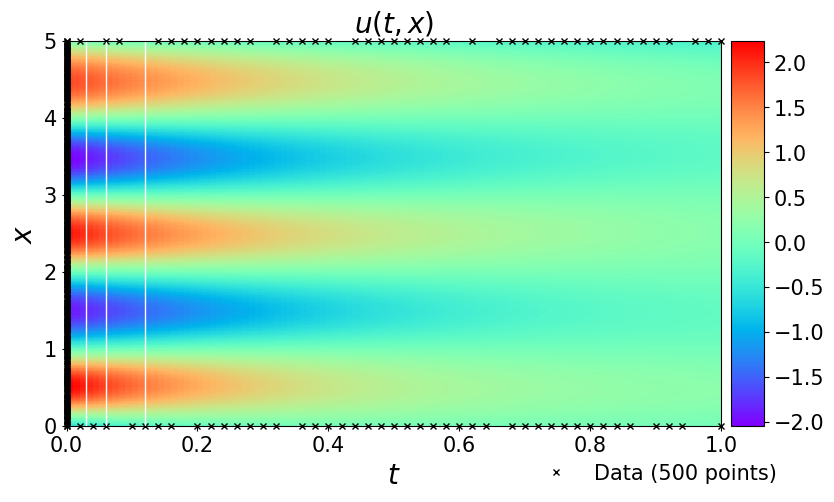

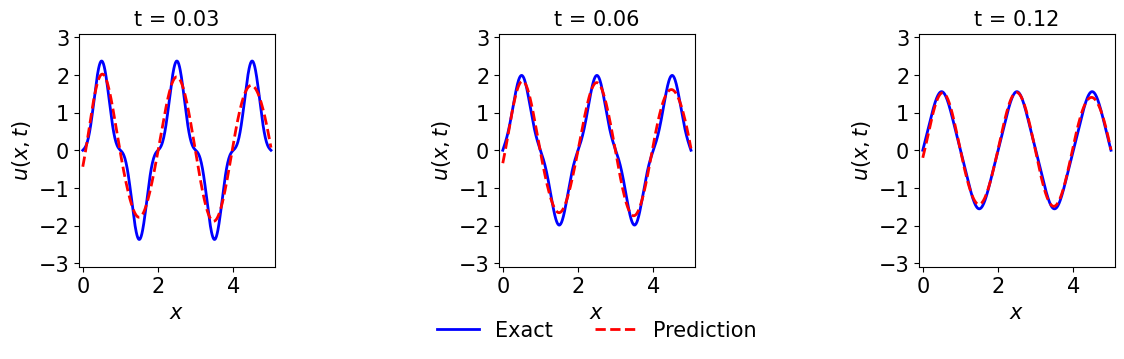

In [10]:
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

#first plot
U_pred = griddata(xt_sol, u_pred_te.flatten(), (X, T), method='cubic')

fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(111)

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t_fine.min(), t_fine.max(), x_fine.min(), x_fine.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.10)
cbar = fig.colorbar(h, cax=cax)
cbar.ax.tick_params(labelsize=15) 

ax.plot(
    xt_train[:,1:2], 
    xt_train[:,0:1], 
    'kx', label = 'Data (%d points)' % (u_train.shape[0]), 
    markersize = 4,  # marker size doubled
    clip_on = False,
    alpha=1.0
)

line = np.linspace(x_fine.min(), x_fine.max(), 2)[:,None]
ax.plot(t_fine[3]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t_fine[6]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t_fine[12]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$', size=20)
ax.set_ylabel('$x$', size=20)
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.9, -0.05), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)
ax.set_title('$u(t,x)$', fontsize = 20) 
ax.tick_params(labelsize=15)

plt.show()


#second plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111)
ax.remove()

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x_fine,U_sol[3,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x_fine,U_pred[3,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(x,t)$')    
ax.set_title(f't = {t_fine[3].item()}', fontsize = 15) 
ax.axis('square')
ax.set_xlim([-0.1,L+0.1]) 
ax.set_ylim([u_sol.min() -0.1,u_sol.max()+0.1]) 

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 1])
ax.plot(x_fine,U_sol[6,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x_fine,U_pred[6,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(x,t)$')
ax.axis('square')
ax.set_xlim([-0.1,L+0.1])
ax.set_ylim([u_sol.min() -0.1,u_sol.max()+0.1])
ax.set_title(f't = {t_fine[6].item()}', fontsize = 15) 
ax.legend(
    loc='upper center', 
    bbox_to_anchor=(0.5, -0.15), 
    ncol=5, 
    frameon=False, 
    prop={'size': 15}
)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

ax = plt.subplot(gs1[0, 2])
ax.plot(x_fine,U_sol[12,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x_fine,U_pred[12,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(x,t)$')
ax.axis('square')
ax.set_xlim([-0.1,L+0.1])
ax.set_ylim([u_sol.min() -0.1 ,u_sol.max()+0.1])    
ax.set_title(f't = {t_fine[12].item()}', fontsize = 15)  

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)

plt.show()

### Plot of the initial solution ($L=5, f=5$)
<br>
<div>
  <img src="img/8.PNG" width="750"/>  
</div>